In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cpu')

In [8]:
print('Device:', device)
print('Count of using GPUs:', torch.cuda.device_count())

Device: cpu
Count of using GPUs: 0


In [9]:
# 이미지를 출력하는 함수
def display_images(image_paths, title, max_images=4):
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

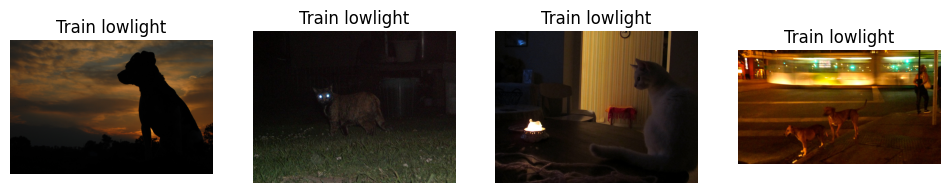

Train lowlight 총 이미지 수: 3686


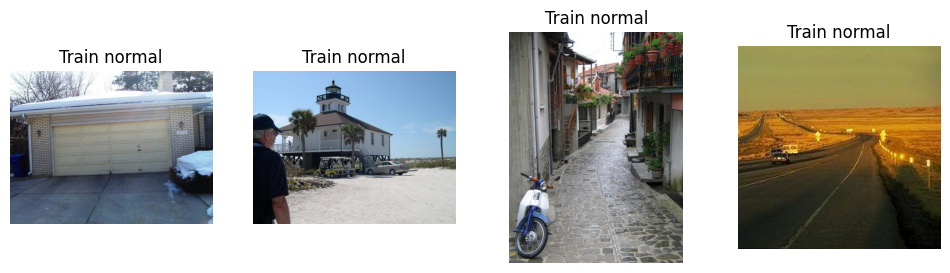

Train normal 총 이미지 수: 3846


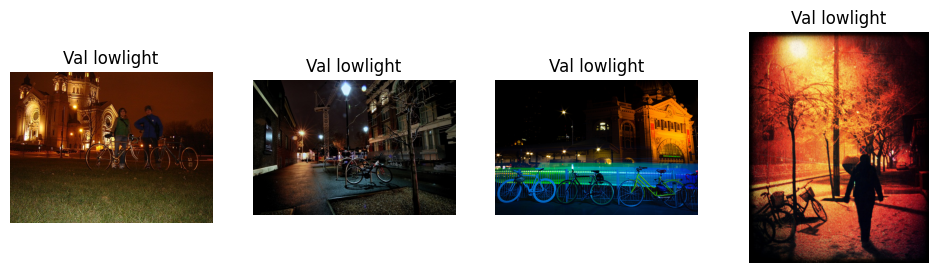

Val lowlight 총 이미지 수: 652


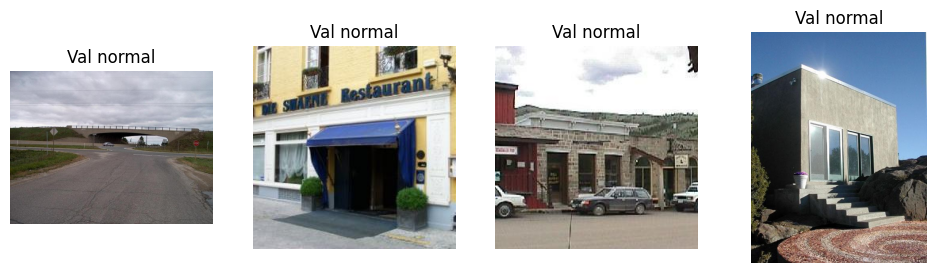

Val normal 총 이미지 수: 689


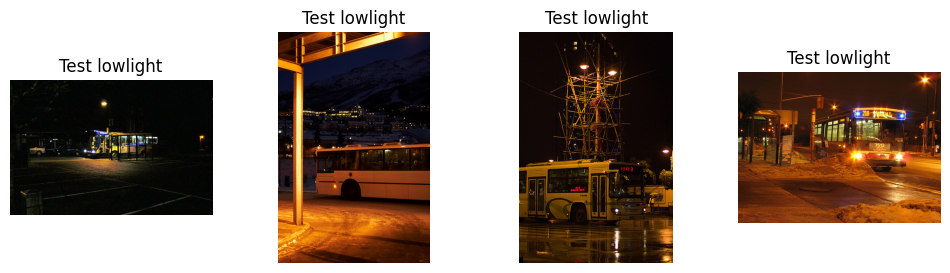

Test lowlight 총 이미지 수: 50


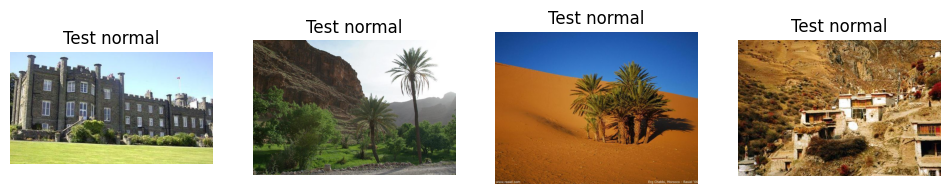

Test normal 총 이미지 수: 50


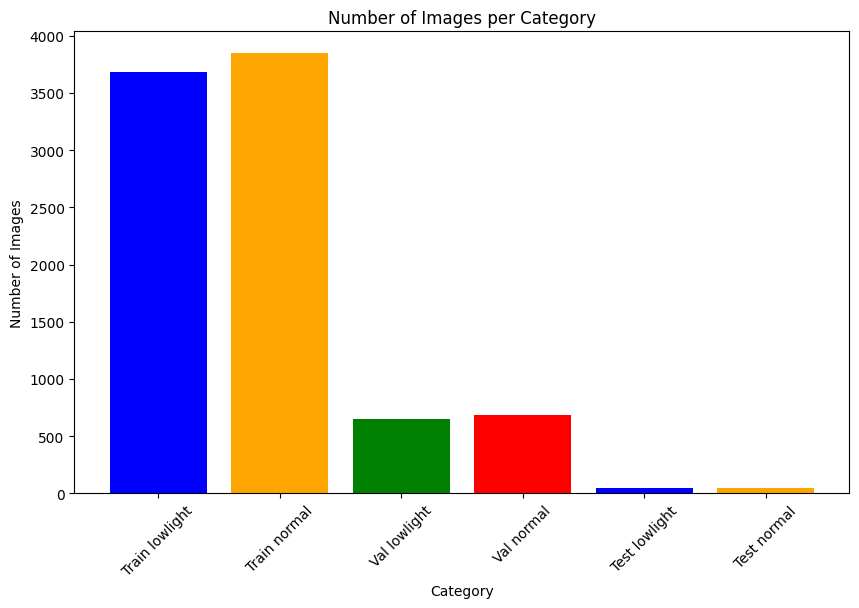

In [10]:

categories = ['Train lowlight', 'Train normal', 'Val lowlight', 'Val normal', 'Test lowlight', 'Test normal']

for category in categories:
    image_paths = glob.glob(f'/Users/taeyoun/Downloads/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/5/{category.lower().replace(" ", "/")}/*')
    display_images(image_paths, category)
    print(f"{category} 총 이미지 수: {len(image_paths)}")

plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/Users/taeyoun/Downloads/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/5/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [12]:
from imgaug import augmenters as iaa
import imgaug as ia

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Fliplr(0.5), 
            iaa.Affine(rotate=(-20, 20), mode='symmetric'), 
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

class ImgAugTransform_Light:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Fliplr(0.5),  
            iaa.Affine(rotate=(-20, 20), mode='symmetric'),  
            iaa.Multiply((0.8, 1.2)),  
            iaa.LinearContrast((0.75, 1.5)), 
            iaa.HistogramEqualization(),
            iaa.CLAHE(),
            iaa.GammaContrast((0.5, 2.0)), 
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

class CustomDataset(ImageFolder):
    def __init__(self, root, imgaug=None, transform=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug  

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [13]:

from torchvision import transforms
pytorch_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [14]:
from torch.utils.data import SubsetRandomSampler

num_of_train = 7532
num_of_val = 1341
train_indices = list(range(num_of_train))
val_indices = list(range(num_of_val))

np.random.shuffle(train_indices)
train_subset_indices = train_indices[:3000]

np.random.shuffle(val_indices)
val_subset_indices = val_indices[:200]

train_sampler = SubsetRandomSampler(train_subset_indices)
val_sampler = SubsetRandomSampler(val_subset_indices)

In [16]:

train_dataset = CustomDataset('/Users/taeyoun/Downloads/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/5/train', imgaug=ImgAugTransform(), transform=pytorch_transforms)
val_dataset = CustomDataset('/Users/taeyoun/Downloads/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/5/val', imgaug=None, transform=pytorch_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, sampler=val_sampler)

In [17]:

def imshow(img, size=(20, 20), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean 
    img = np.clip(img, 0, 1)  
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

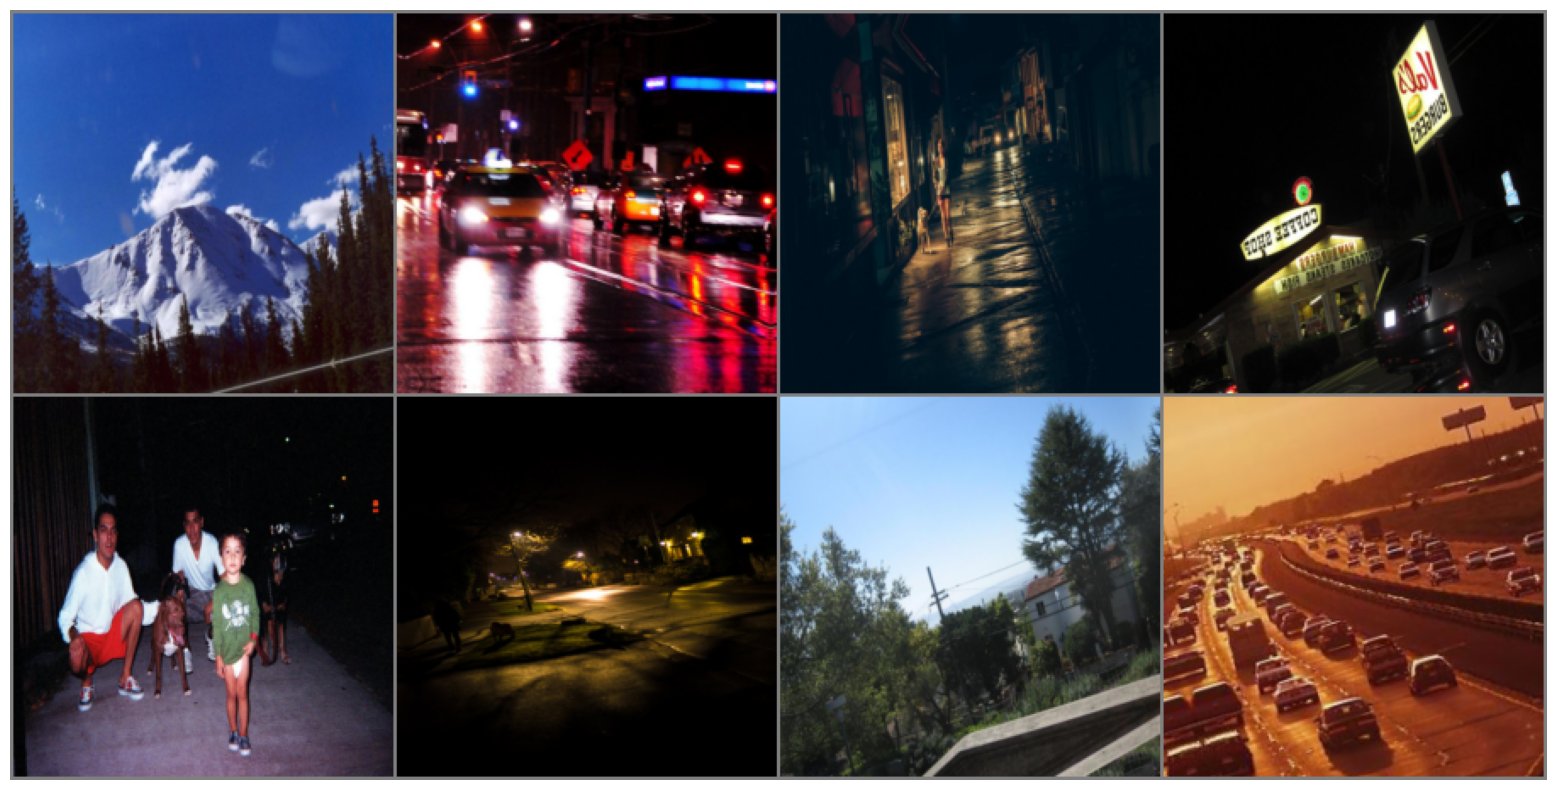

In [18]:

dataiter = iter(train_loader)
images, _ = next(dataiter)

imshow(make_grid(images[:8], nrow=4), size=(20, 10))

In [19]:

net = models.resnet50(pretrained=True)
net

/opt/anaconda3/envs/imgaug1203/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/imgaug1203/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/taeyoun/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:

for param in net.parameters():
    param.requires_grad = False

In [21]:

net.fc = nn.Linear(2048, 2)
net.fc.requires_grad = True

In [22]:
net = net.to(device)

In [23]:

criterion = nn.CrossEntropyLoss()

In [27]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=2):
    # optimizer설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(net.parameters(), lr=0.001, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train() 
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        net.eval()  
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                probabilities = F.softmax(outputs, dim=1) 
                _, predicted = torch.max(probabilities, 1) 
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [28]:
train_losses_default_aug, val_losses_default_aug, val_accuracies_default_aug = train_model('RAdam', net, train_loader, val_loader, criterion)

[RAdam] Epoch 1, Train Loss: 0.155075, Val Loss: 0.161995, Validation Accuracy: 94.00%
[RAdam] Epoch 2, Train Loss: 0.126451, Val Loss: 0.116844, Validation Accuracy: 96.50%


In [29]:
train_losses_default_aug, val_losses_default_aug, val_accuracies_default_aug = train_model('AdamW', net, train_loader, val_loader, criterion)

[AdamW] Epoch 1, Train Loss: 0.110092, Val Loss: 0.105529, Validation Accuracy: 97.00%
[AdamW] Epoch 2, Train Loss: 0.098203, Val Loss: 0.087971, Validation Accuracy: 98.00%


In [30]:

train_dataset = CustomDataset('/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/5/train', imgaug=ImgAugTransform_Light(), transform=pytorch_transforms)
train_loader = DataLoader(dataset=train_dataset, batch_size=8, sampler=train_sampler)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/taeyoun/Downloads/DeepLearning/project/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/5/train'

In [ ]:

dataiter = iter(train_loader)
images, _ = next(dataiter)

imshow(make_grid(images[:8], nrow=4), size=(20, 10))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:

net = models.resnet50(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
net.fc = nn.Linear(2048, 2)
net.fc.requires_grad = True

net = net.to(device)

In [ ]:
train_losses_light_aug, val_losses_light_aug, val_accuracies_light_aug = train_model('Adam', net, train_loader, val_loader, criterion)

[Adam] Epoch 1, Train Loss: 0.310031, Val Loss: 0.166250, Validation Accuracy: 92.50%
[Adam] Epoch 2, Train Loss: 0.210757, Val Loss: 0.134918, Validation Accuracy: 94.00%
[Adam] Epoch 3, Train Loss: 0.198087, Val Loss: 0.074229, Validation Accuracy: 97.00%
[Adam] Epoch 4, Train Loss: 0.214350, Val Loss: 0.080487, Validation Accuracy: 98.00%
[Adam] Epoch 5, Train Loss: 0.191586, Val Loss: 0.068898, Validation Accuracy: 96.50%
[Adam] Epoch 6, Train Loss: 0.213041, Val Loss: 0.072869, Validation Accuracy: 96.50%
[Adam] Epoch 7, Train Loss: 0.234613, Val Loss: 0.077840, Validation Accuracy: 96.50%
[Adam] Epoch 8, Train Loss: 0.167105, Val Loss: 0.061504, Validation Accuracy: 96.50%
[Adam] Epoch 9, Train Loss: 0.174567, Val Loss: 0.131206, Validation Accuracy: 93.50%
[Adam] Epoch 10, Train Loss: 0.201512, Val Loss: 0.096358, Validation Accuracy: 94.00%
[Adam] Epoch 11, Train Loss: 0.201961, Val Loss: 0.089306, Validation Accuracy: 97.00%
[Adam] Epoch 12, Train Loss: 0.166570, Val Loss: 0.0

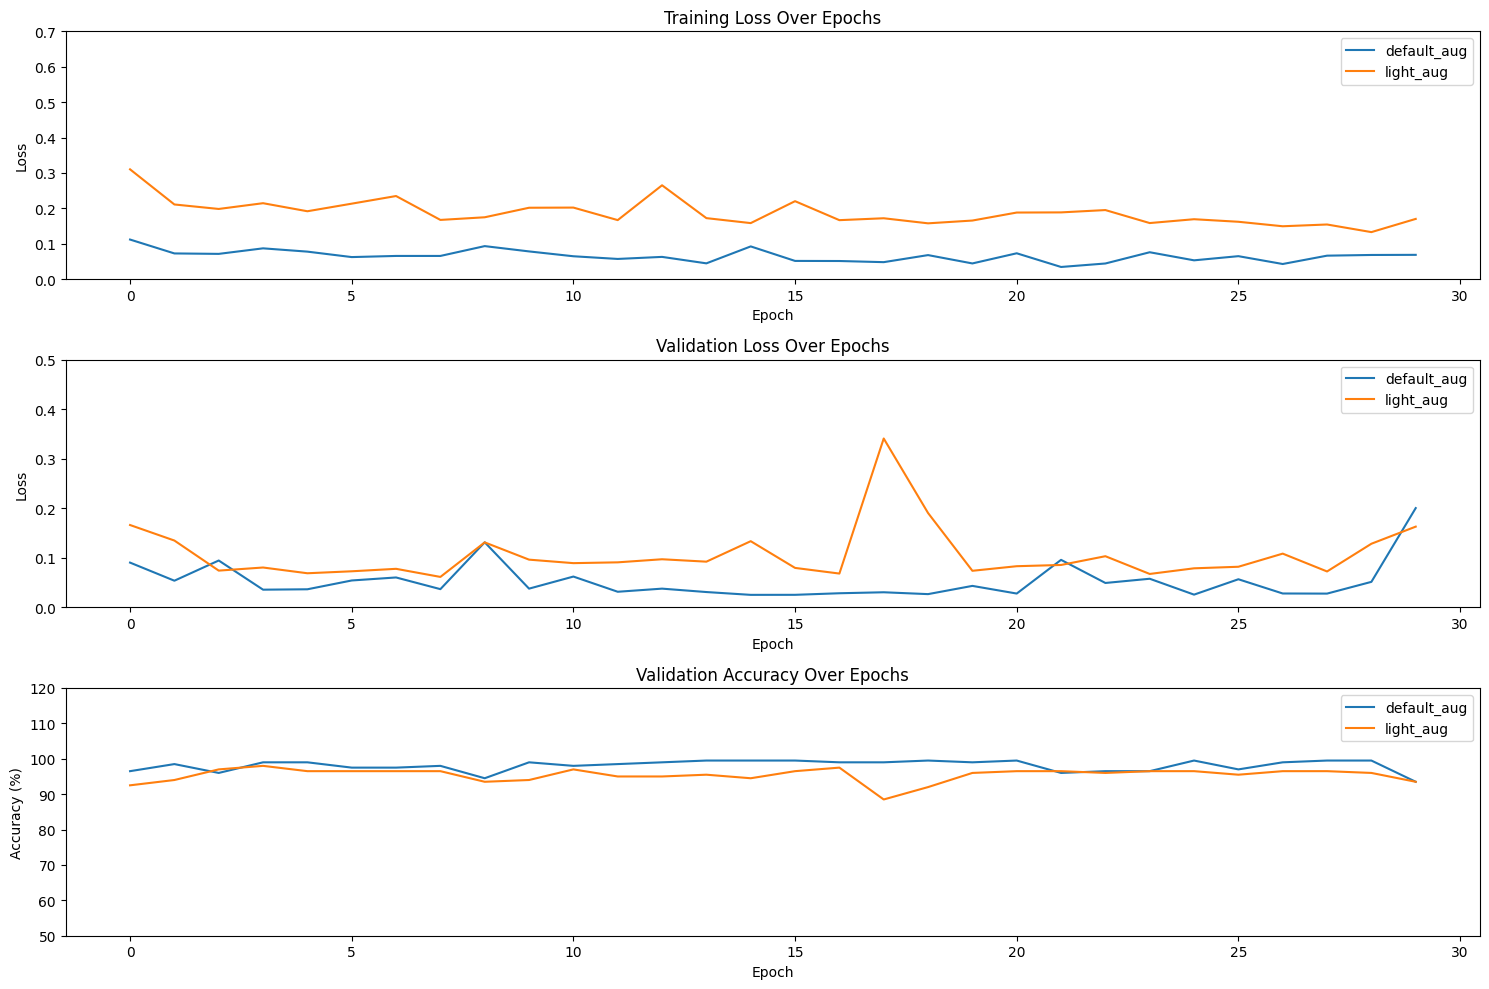

In [ ]:

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1) 
plt.plot(train_losses_default_aug, label='default_aug')
plt.plot(train_losses_light_aug, label='light_aug')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.ylim(0, 0.7)

plt.subplot(3, 1, 2)  
plt.plot(val_losses_default_aug, label='default_aug')
plt.plot(val_losses_light_aug, label='light_aug')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.ylim(0, 0.5)


plt.subplot(3, 1, 3)  
plt.plot(val_accuracies_default_aug, label='default_aug')
plt.plot(val_accuracies_light_aug, label='light_aug')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.ylim(50, 120)  

plt.tight_layout()
plt.show()

In [ ]:

def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device) 

In [ ]:

class_folders = {
    'lowlight': '/Users/taeyoun/Downloads/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/5/test/lowlight',
    'normal': '/Users/taeyoun/Downloads/DeepLearning/project/Image_DL_Fastcampus/Part 1/Chapter 1. Binary Classification _ 두 선택지 중 하나를 선택하여 판별하는 분류 방법/실습 파일/5/test/normal'
}

plt.figure(figsize=(20, 8))
counter = 1

for class_name, folder_path in class_folders.items():
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, pytorch_transforms)

        net.eval()
        with torch.no_grad():
            outputs = net(image)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probabilities, 1) 
        prediction = 'lowlight' if predicted.item() == 0 else 'normal'

        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.